In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

The example code by [Moustafa](https://github.com/malzantot) got on average 86-89% success rate, I thought I could do better given that Open AI's standards for solving this environment is 99% success rate over 100 trials.  In this code the env.env.P function is used which returns all the MDP values for a given state.  This  function I beleive is only available on FrozenLake and Taxi.

In [2]:
env = gym.make('FrozenLake8x8-v0')

[2017-11-20 10:27:31,269] Making new env: FrozenLake8x8-v0


In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

Implemented By Using Pseudo Code From: <br />
[Reinforcement Learning: An Introduction](http://www.incompleteideas.net/sutton/book/the-book-2nd.html) <br />
By: Rich Sutton

<img src="images/value.png">

In [4]:
values = np.zeros(n_states)
gamma = 0.999

In [5]:
while True:
    delta = 0
    for states in reversed(range(n_states)):
        v = values[states]
        values[states] = np.max([sum([p*(r + gamma*values[s_]) for p, s_, r, _ in env.env.P[states][a]]) for a in range(env.env.nA)])
        delta = max(delta,abs(v-values[states]))
    if delta < 1e-30:
        break
    

In [6]:
history = []
bestAverage = []
state = env.reset()
test_episodes = 1000

for i in range(1,test_episodes):
    while True:
        action = np.argmax([sum([p*(r + gamma*values[s_]) for p, s_, r, _ in env.env.P[state][a]]) for a in range(env.env.nA)])
        state, reward, done, info = env.step(action)

        if done:
            history.append(reward)
            env.reset()
            break

    if len(history)>=100 and np.mean(history[i-100:i]) >= 0.80:
        bestAverage.append(np.mean(history[i-100:i]))
print('Best Average Score Per 100 Episodes in {} Episodes: {:4.3f}'.format(test_episodes, np.max(bestAverage)))

Best Average Score Per 100 Episodes in 1000 Episodes: 0.970


3-D Graph of State Values
----------------------------

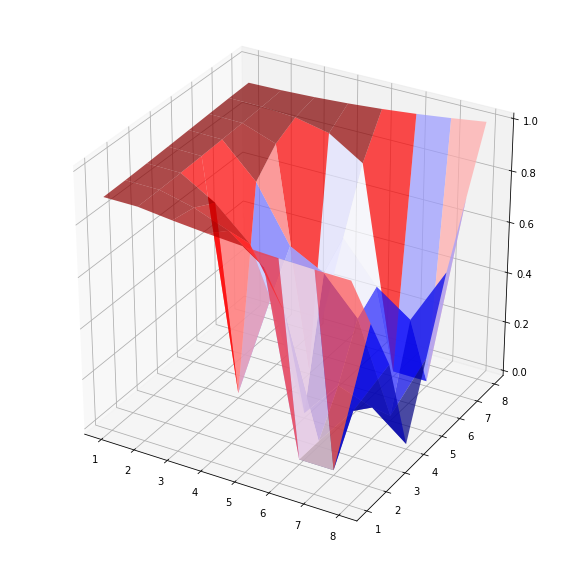

In [7]:
fig = plt.figure(figsize=(10,10))
values2 = values.reshape(8,8)
# Overide value of goal state to make graph nicer
values2[7,7] = 1
ax = plt.axes(projection='3d')
x = np.outer(np.linspace(1,8,8), np.ones(8))
y = x.copy().T
z = values2
ax.plot_surface(x, y, z, cmap='seismic', rstride=1, cstride=1, linewidth=0, alpha=0.7)
plt.show()
plt.close()



Value Iteration assumes that the entire MDP is known but in most cases the MDP is unknown.  I thought I would try and solve FrozenLake-v0 by trying to estimate all p(s',r|s,a) and state values and by using e-greedy Q-Learning.

In [8]:
env = gym.make('FrozenLake-v0')

[2017-11-20 10:27:36,368] Making new env: FrozenLake-v0


In [9]:
n_states = env.observation_space.n
n_actions = env.action_space.n


In [10]:
env.render()


SFFF
FHFH
FFFH
HFFG


We can also think of our states like the following.

In [11]:
states = np.zeros([n_states])
for i in range(n_states):
    states[i] = i
states.reshape(4,4)

array([[  0.,   1.,   2.,   3.],
       [  4.,   5.,   6.,   7.],
       [  8.,   9.,  10.,  11.],
       [ 12.,  13.,  14.,  15.]])

There are 4 possible actions with their associated labels

[0] = Left

[1] = Down    

[2] = Right    

[3] = Up

In [12]:
table = np.zeros([n_states,n_states,n_actions,4])

Table represents the number of initial states (**s**), future states (**s'**), number of possible actions(**a**), and the last 4 indexes represent:

[0] - Reward

[1] - How many times action is taken given state (**#a|s**) 

[2] - How many times state transitioned to **s'** given **a** (**#s'|a**)

[3] - Probability of transitioning to **s'** from **s** given action **a** (**p(s'|s,a)**)

Since the rewards for state transitions do not change we do not need to calculate **p(s'|s,a**)



Let's make a function that can evaluate all possible state transitions for any given state.

In [13]:
def possibleStates(s):
    p_states = []
    for i in range(n_states):
        if np.max(table[s,i,:,[3]]):
            p_states.append(i)
    return p_states

def actionProbs(s):
    for i in possibleStates(s):
        print('-----------------------------------------------------')
        for a in range(n_actions):
            print('P: State: [{}] -> State: [{}] via Action: [{}] is {:4.4f}'.format(s,i,a,table[s,i,a,3]))


Let's evaluate the probability of each state transition from state[0] by sampling all possible actions from the initial state 100,000 times.  By [law of large numbers](https://www.youtube.com/watch?v=Ws63I3F7Moc) we will converge to the state transition probabilities.  

In [14]:
for i in range(n_actions):
    for _ in range(10000):
        state = env.reset()
        action = i
        state2, reward, done, info = env.step(action)

        table[state,state2,action,0] = reward
        table[state,:,action,1] += 1
        table[state,state2,action,2] += 1
        table[state,:,action,3] = table[state,:,action,2] / table[state,:,action,1]

And now we can display the probability of transitioning to any possible future state given any action.

In [15]:
actionProbs(env.reset())

-----------------------------------------------------
P: State: [0] -> State: [0] via Action: [0] is 0.6666
P: State: [0] -> State: [0] via Action: [1] is 0.3377
P: State: [0] -> State: [0] via Action: [2] is 0.3249
P: State: [0] -> State: [0] via Action: [3] is 0.6707
-----------------------------------------------------
P: State: [0] -> State: [1] via Action: [0] is 0.0000
P: State: [0] -> State: [1] via Action: [1] is 0.3345
P: State: [0] -> State: [1] via Action: [2] is 0.3403
P: State: [0] -> State: [1] via Action: [3] is 0.3293
-----------------------------------------------------
P: State: [0] -> State: [4] via Action: [0] is 0.3334
P: State: [0] -> State: [4] via Action: [1] is 0.3278
P: State: [0] -> State: [4] via Action: [2] is 0.3348
P: State: [0] -> State: [4] via Action: [3] is 0.0000


So if we wanted to transition to state 4, the best possible action is [0] (LEFT) because from state 0 we will have a 66% chance of staying in state 0 and a 33% chance of transitioning to state 4.  

One way to solve this environment we will have to sample it a large amount of times and keep track of the estimated value of each state.  We will create a value table of 16 for each possible states.  We update our state value using the TD Target also known as Tabular TD(0) for estimating V(pi) the optimal values.  We will use learning rate alpha to determine the rate of update we apply to V(s).  The value can be considered our expected return in a given state.  We will explore the environment by behaving completely randomly updating the values at the same time which will be used later for another policy for completeing the environment.  This is also known as off-policy learning since we are not adapting the policy we are using to explore the environment.  Since it's exploring randomly it sometimes does not converge nicely without a very large amount of episodes. 

In [16]:
value = np.zeros([n_states])
table = np.zeros([n_states,n_states,n_actions,4])

In [17]:
gamma = 0.999
alpha = 0.1
history = []
state = env.reset()
n_episodes = 500000
n_steps = 500
n_solved = 0
for i in range(n_episodes):
    state = env.reset()
    for _ in range(n_steps):
        action = env.action_space.sample()
        state2, reward, done, info = env.step(action)

        table[state,state2,action,0] = reward
        table[state,:,action,1] += 1
        table[state,state2,action,2] += 1
        table[state,:,action,3] = table[state,:,action,2] / table[state,:,action,1]
        
        value[state] += alpha*(reward + gamma*value[state2] - value[state])
        
        state = state2
        if done:
            if reward == 1:
                n_solved += 1
            break
              
print('Solved {} Times In {} Episodes with average reward of {}'.format(n_solved, i+1, n_solved/n_episodes))

Solved 7042 Times In 500000 Episodes with average reward of 0.014084


In [18]:
value2 = value.reshape(4,4)
for i in range(4):
    print(value2[i,:])

[ 0.02251488  0.01525417  0.03314086  0.01129801]
[ 0.02690182  0.          0.05351512  0.        ]
[ 0.06357931  0.12946447  0.12067885  0.        ]
[ 0.          0.22077559  0.53832208  0.        ]


So the holes and and goal point do not have any values because they do not lead to any future states.  When trying to estimate the best action to take we will take the probabilities of of all actions that lead to the best state and subtract them by worst state.  This ensures that actions that have a probability of leading to a worse state are not considered.  Since the holes and and finish point do not have values we will assign their values to be the expected reward for transitioning to that state.

In [19]:
def bestState(s):
    beststate = s
    for i in possibleStates(s):
        if value[i] + np.max(table[:,i,:,0]) > value[beststate]:
            beststate = i
    return beststate

def worstState(s):
    worststate = s
    for i in possibleStates(s):
        if value[i] + np.max(table[:,i,:,0]) < value[worststate]:
            worststate = i
    return worststate

def bestAction(s):
    a = np.argmax((table[s,bestState(s),:,[3]])-(table[s,worstState(s),:,[3]]))
    return a

In [20]:
history = []
for i in range(1,1000):
    while True:
        action = bestAction(state)
        state, reward, done, info = env.step(action)

        if done:
            history.append(reward)
            env.reset()
            break

    # Open AI's Standards For Solving
    if len(history)>=100 and np.mean(history[i-100:i]) >= 0.78:
        print('Solved in {} attempts'.format(i))
        break


Solved in 227 attempts


There we have it by only behaving completely random and updating our expected state values we are able to solve the environment.  Here is the graph of the estimated state values. [1,1] represents the start state and [4,4] the finish state.

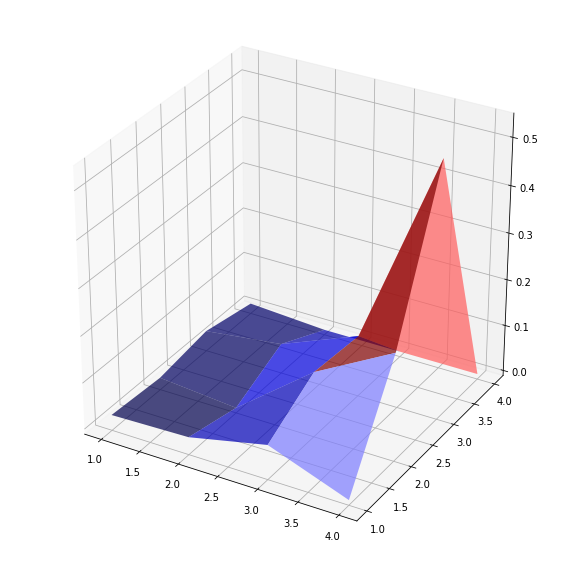

In [21]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
x = np.outer(np.linspace(1, 4, 4), np.ones(4))
y = x.copy().T
z = value2
ax.plot_surface(x, y, z, cmap='seismic', rstride=1, cstride=1, linewidth=0, alpha=0.7)
plt.show()
plt.close()


Also here is some old code I used for solving this environment using e-greedy Q-Learning (Action Value), which is a hell of alot less complicated then my previous method.  This e-greedy method also incorporates some random action noise which decays over each episode.  This method is on-policy and solves much faster because it's improving the Q-Value based policy every time step.

<img src="images/qlearn.png">

In [22]:
def e_greedy(eps, Q, state, episode):
    
    if np.random.rand() > eps:
        action = np.argmax(Q[state,:]+np.random.randn(1, n_actions)/(episode/4))
    else:
        action = env.action_space.sample()
        eps -= 10**-5

    return action, eps

In [23]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
rewardTracker = []

alpha = 0.8
gamma = 0.95
eps = 0.1
numTrainingEpisodes = 5000
numTrainingSteps = 300

for episode in range(1,numTrainingEpisodes+1):  

    G = 0
    state = env.reset()

    for step in range(1,numTrainingSteps):

        action, eps = e_greedy(eps, Q, state, episode)
        state2, reward, done, info = env.step(action)
        Q[state,action] += alpha * (reward + gamma * np.max(Q[state2]) - Q[state,action])
        state = state2
        G += reward

    rewardTracker.append(G)

    if episode % (numTrainingEpisodes*.10) == 0 and episode != 0:
        print('Alpha {}  Gamma {}  Epsilon {:04.3f}  Episode {} of {}'.format(alpha, gamma, eps, episode, numTrainingEpisodes))
        print("Average Total Return: {}".format(sum(rewardTracker)/episode))

    if (sum(rewardTracker[episode-100:episode])/100.0) > .78:
        print('-------------------------------------------------------')
        print('Solved after {} episodes with average return of {}'.format(episode-100, sum(rewardTracker[episode-100:episode])/100.0))
        break


Alpha 0.8  Gamma 0.95  Epsilon 0.022  Episode 500 of 5000
Average Total Return: 0.114
Alpha 0.8  Gamma 0.95  Epsilon 0.005  Episode 1000 of 5000
Average Total Return: 0.24
Alpha 0.8  Gamma 0.95  Epsilon 0.001  Episode 1500 of 5000
Average Total Return: 0.368
-------------------------------------------------------
Solved after 1540 episodes with average return of 0.79


Here's the graphs for all the action values.

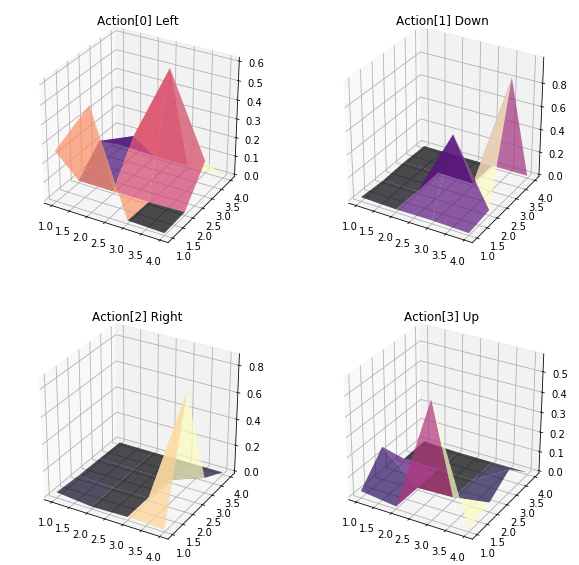

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221,projection='3d')
x = np.outer(np.linspace(1, 4, 4), np.ones(4))
y = x.copy().T

ax.plot_surface(x, y, Q[:,0].reshape(4,4), cmap='magma', rstride=1, cstride=1, linewidth=0, alpha=0.7)
plt.title('Action[0] Left')

ax = fig.add_subplot(222,projection='3d')
ax.plot_surface(x, y, Q[:,1].reshape(4,4), cmap='magma', rstride=1, cstride=1, linewidth=1, alpha=0.7)
plt.title('Action[1] Down')

ax = fig.add_subplot(223,projection='3d')
ax.plot_surface(x, y, Q[:,2].reshape(4,4), cmap='magma', rstride=1, cstride=1, linewidth=1, alpha=0.7)
plt.title('Action[2] Right')

ax = fig.add_subplot(224,projection='3d')
ax.plot_surface(x, y, Q[:,3].reshape(4,4), cmap='magma', rstride=1, cstride=1, linewidth=1, alpha=0.7)
plt.title('Action[3] Up')

plt.show()
plt.close()